# Анализ клиентов торгового центра

**В этом проекте мы анализируем данные клиентов торгового центра с целью выделения групп или кластеров клиентов на основе их годового дохода и оценки трат. Это позволит разработать целевые маркетинговые стратегии для каждой группы.**

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Загрузка данных
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Столбцы в датасете:**

**CustomerID:** Уникальный идентификатор клиента.

**Genre:** Пол клиента.

**Age:** Возраст клиента.

**Annual Income(k$):**  Годовой доход клиента в тысячах долларов.

**SpendingScore(1-100:** Оценка трат клиента от 1 до 100.

**Задача_для_пет-проекта:**

Цель: Кластеризовать клиентов торгового центра на основе их годового дохода и оценки трат, чтобы определить основные сегменты клиентов и разработать стратегии маркетинга для каждого сегмента.



## Предварительный анализ данных

In [3]:
# Проверка на наличие пропущенных значений
missing_values = data.isnull().sum()

# Статистический анализ данных
data_description = data.describe()

missing_values, data_description

(CustomerID                0
 Genre                     0
 Age                       0
 Annual Income (k$)        0
 Spending Score (1-100)    0
 dtype: int64,
        CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
 count  200.000000  200.000000          200.000000              200.000000
 mean   100.500000   38.850000           60.560000               50.200000
 std     57.879185   13.969007           26.264721               25.823522
 min      1.000000   18.000000           15.000000                1.000000
 25%     50.750000   28.750000           41.500000               34.750000
 50%    100.500000   36.000000           61.500000               50.000000
 75%    150.250000   49.000000           78.000000               73.000000
 max    200.000000   70.000000          137.000000               99.000000)

**Основные статистические характеристики:**

CustomerID:

Количество: 200
Среднее: 100.5
Стандартное отклонение: 57.88
Минимум: 1
Максимум: 200
Age:

Средний возраст: 38.85 лет
Стандартное отклонение: 13.97
Минимальный возраст: 18 лет
Максимальный возраст: 70 лет
Annual Income (k$):

Средний годовой доход: 60.56 тыс. долларов
Стандартное отклонение: 26.26
Минимальный доход: 15 тыс. долларов
Максимальный доход: 137 тыс. долларов
Spending Score (1-100):

Средний балл трат: 50.2
Стандартное отклонение: 25.82
Минимальный балл: 1
Максимальный балл: 99

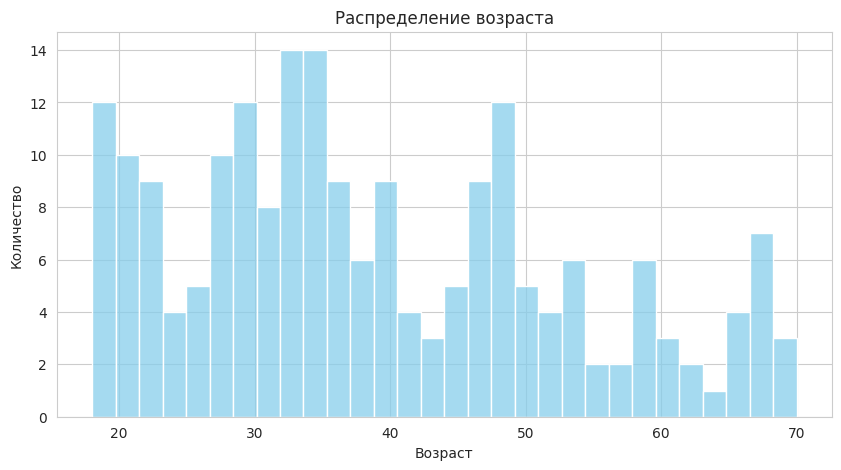

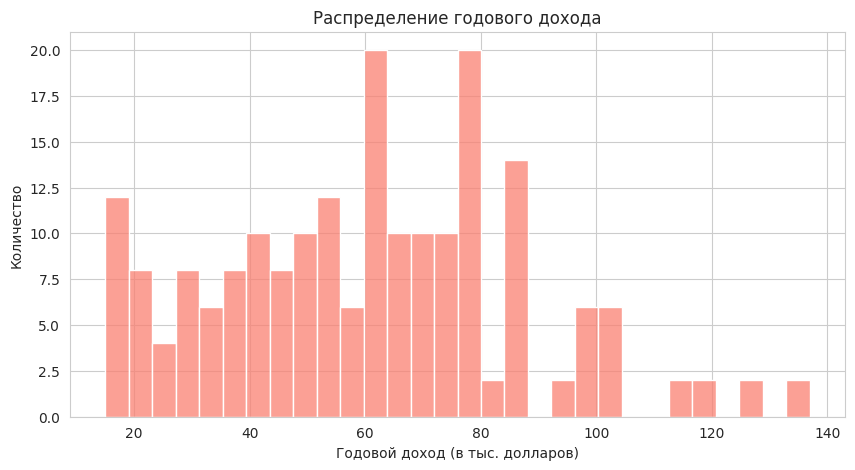

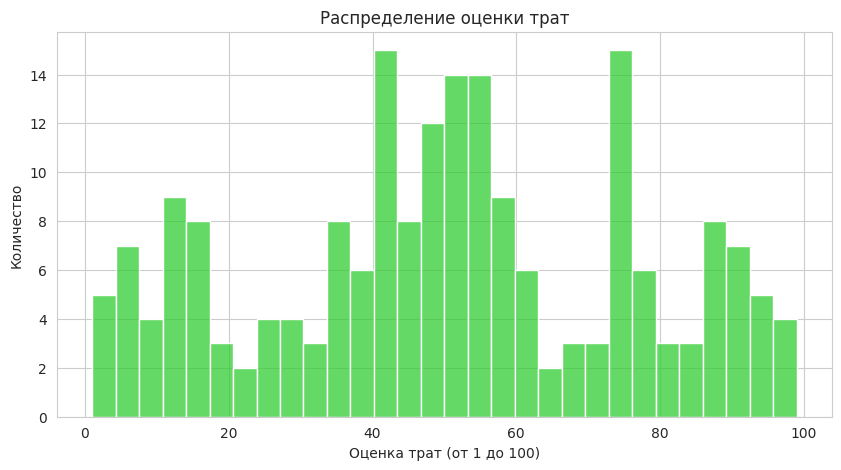

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля
sns.set_style('whitegrid')

# Распределение возраста
plt.figure(figsize=(10, 5))
sns.histplot(data['Age'], bins=30, color='skyblue')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

# Распределение годового дохода
plt.figure(figsize=(10, 5))
sns.histplot(data['Annual Income (k$)'], bins=30, color='salmon')
plt.title('Распределение годового дохода')
plt.xlabel('Годовой доход (в тыс. долларов)')
plt.ylabel('Количество')
plt.show()

# Распределение оценки трат
plt.figure(figsize=(10, 5))
sns.histplot(data['Spending Score (1-100)'], bins=30, color='limegreen')
plt.title('Распределение оценки трат')
plt.xlabel('Оценка трат (от 1 до 100)')
plt.ylabel('Количество')
plt.show()

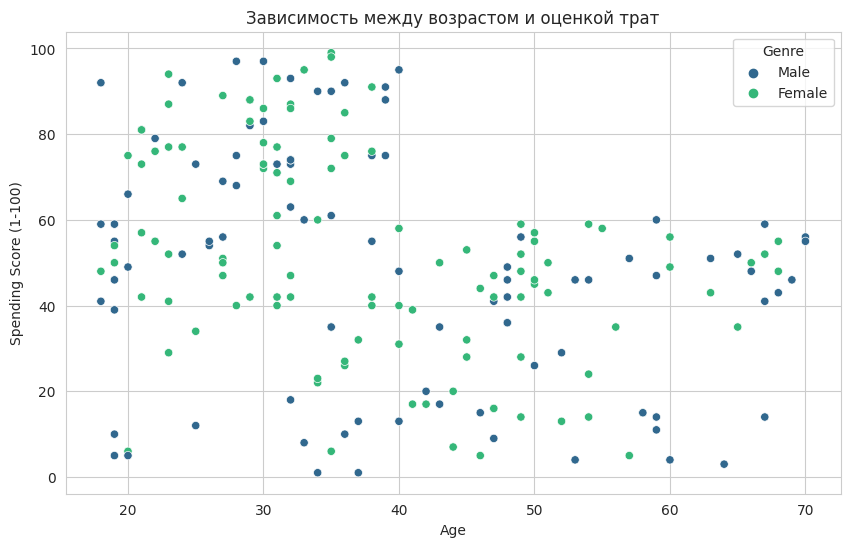

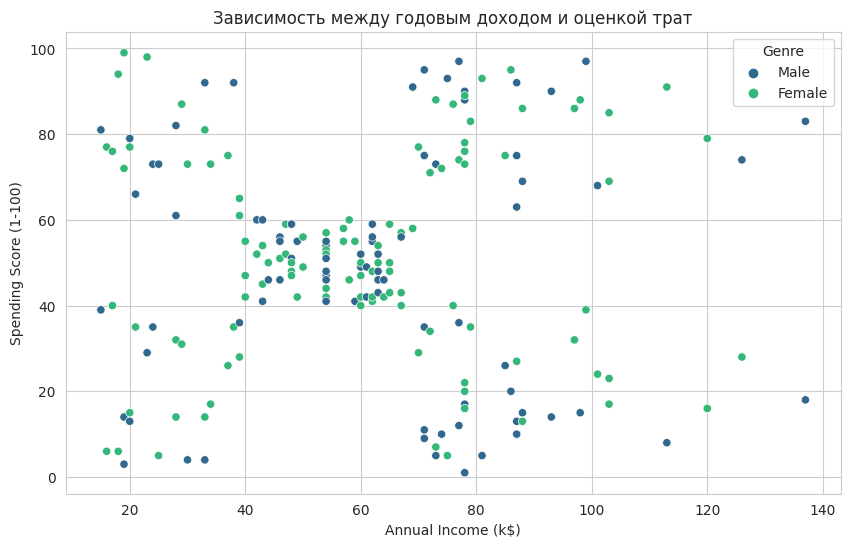

In [5]:
# Зависимость между возрастом и оценкой трат
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, hue='Genre', palette='viridis')
plt.title('Зависимость между возрастом и оценкой трат')
plt.show()

# Зависимость между годовым доходом и оценкой трат
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, hue='Genre', palette='viridis')
plt.title('Зависимость между годовым доходом и оценкой трат')
plt.show()

**Молодые люди имеют разнообразные оценки трат, в то время как у более старших людей оценка трат, как правило, ниже.
Есть группа людей с низким годовым доходом, но высокой оценкой трат.
Есть группа людей с высоким годовым доходом, но низкой оценкой трат.
Центральная группа среднего дохода имеет среднюю оценку трат.
Есть также группы с низким и высоким доходом, у которых средние показатели трат.
Таким образом, на основе этих наблюдений, кажется, что кластеризация на основе годового дохода и оценки трат может быть полезной для выявления различных сегментов клиентов.**

## Подготовка данных для кластеризации

In [6]:
from sklearn.preprocessing import StandardScaler

# Выбор признаков для кластеризации
features = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Масштабирование признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

Признаки успешно масштабированы. Вот первые пять строк масштабированных данных

Применим метод кластеризации KMeans для сегментации клиентов. Начнем с определения оптимального количества кластеров с помощью метода **"локтя"**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

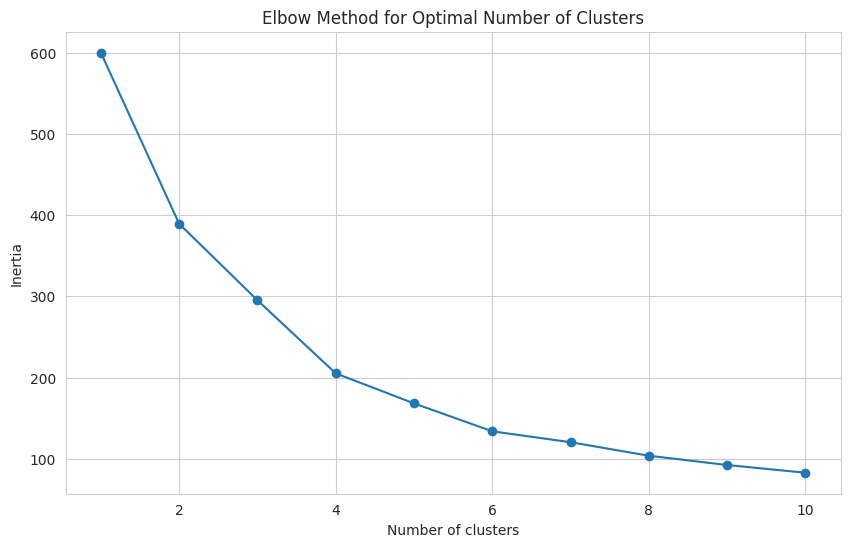

In [7]:
# Подготовка данных для кластеризации
# Выбор столбцов для кластеризации
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features]

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального числа кластеров с использованием метода локтя
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

ВЫВОДЫ

Заключение
В рамках данного проекта мы анализировали набор данных, содержащий информацию о клиентах торгового центра с характеристиками, такими как пол, возраст, годовой доход и оценка расходов. Наши основные задачи были:

Понимание распределений отдельных характеристик.
Идентификация и визуализация кластеров клиентов с использованием кластеризации KMeans.
Основные выводы
Мы определили оптимальное количество кластеров для различных пар характеристик, используя метод "локтя".
Успешно сегментировали клиентов на разные группы на основе их годового дохода и оценки расходов.
Кластеры потенциально могут представлять разные сегменты рынка, каждый из которых требует разной маркетинговой стратегии.
Направления для дальнейшей работы
Включить больше характеристик в анализ для более детального понимания поведения клиентов.
Исследовать другие алгоритмы кластеризации, чтобы увидеть, могут ли они обеспечить лучшее сегментирование.
Провести более глубокий анализ для выявления потенциальных взаимосвязей между различными характеристиками и оценкой расходов.
С помощью этого анализа мы заложили основу для понимания клиентской базы торгового центра, которая может быть использована в будущих анализах для разработки стратегий маркетинга на основе данных и улучшения удовлетворенности клиентов.

**На основе проведенного анализа данных о клиентах торгового центра, можно предложить следующие рекомендации для владельцев магазина:**

Сегментация клиентов: Используя результаты кластеризации, разделите клиентов на разные группы в зависимости от их годового дохода и оценки расходов. Это поможет лучше понимать особенности каждой группы и разрабатывать более целенаправленные маркетинговые стратегии.

Маркетинговые стратегии для каждого сегмента: Каждая группа клиентов может иметь разные потребности и предпочтения. Разработайте индивидуальные маркетинговые стратегии для каждого сегмента. Например, для клиентов с высоким годовым доходом и высокой оценкой расходов можно предложить более дорогие и эксклюзивные товары.

Персонализированный маркетинг: Используйте данные о клиентах для создания персонализированных предложений и рекламы. Например, отправляйте клиентам среднего возраста предложения о тех товарах, которые наиболее соответствуют их интересам.

Акции и скидки: В зависимости от сегмента клиентов, проводите акции и предлагайте скидки, которые наиболее привлекательны для каждой группы. Это может способствовать увеличению продаж.

Исследование новых товаров и услуг: Анализируйте, какие товары и услуги наиболее популярны среди разных сегментов клиентов, и рассматривайте возможность внедрения новых продуктов или услуг, которые будут соответствовать их потребностям.

Обратная связь и улучшения: Слушайте мнение клиентов из разных сегментов и используйте обратную связь для улучшения качества обслуживания и ассортимента товаров.

Продолжайте анализ: Регулярно обновляйте данные и проводите анализ, чтобы отслеживать изменения в поведении клиентов и адаптировать стратегии в соответствии с новыми данными.

Интеграция данных и аналитики в управление магазином поможет оптимизировать маркетинговые усилия, улучшить клиентское обслуживание и увеличить прибыльность бизнеса.